# Importing the necessary libraries

In [1]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
import time
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Defining the transforms to apply on the dataset and defining the data loader

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [3]:
batch_size = 512
num_workers = 4  
pin_memory = True  # Enable for faster data transfer if using GPU
dataset = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/train', transform=data_transforms)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
dataset_val = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/val', transform=data_transforms)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
dataset_test = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/test', transform=data_transforms)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# Checking if a GPU is available, else training on CPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Training on {torch.cuda.get_device_name()}")
else:
    print(f"Training on CPU")

Training on Tesla P100-PCIE-16GB


# Defining the resnet 18 Model from torch vision

In [5]:
if not os.path.exists("resnet18"):
    os.mkdir("resnet18")


# Define ResNet-152 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Defining the loss function and Optimizer as adamW
We will using a learning schedular which decays if val loss does not reduce for a few epochs

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Model Training

In [7]:
num_epochs = 40
best_val_accuracy = 0.0


csv_filename = "resnet18/training_log.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Time (s)"])

# Initialize variables for best model tracking
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy for this epoch
    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy for this epoch
    val_accuracy = 100 * correct_val / total_val
    scheduler.step(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    # Print and log epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, " 
          f"Val Loss: {val_loss/len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

    # Log results to CSV file
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, running_loss/len(train_loader), val_loss/len(val_loader), train_accuracy, val_accuracy, epoch_time])

    # Check if this is the best model so far based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_epoch = epoch + 1
        # Save the best model checkpoint
        best_model_path = f"resnet18/best.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, best_model_path)

torch.save(model.state_dict(), "resnet18/last.pt")
print("Training complete")

Epoch 1/40, Training Loss: 0.2372, Val Loss: 0.2196, Train Accuracy: 91.04%, Val Accuracy: 91.86%, Time: 794.98 seconds
Epoch 2/40, Training Loss: 0.1502, Val Loss: 0.1685, Train Accuracy: 94.35%, Val Accuracy: 93.78%, Time: 671.43 seconds
Epoch 3/40, Training Loss: 0.1174, Val Loss: 0.1750, Train Accuracy: 95.55%, Val Accuracy: 93.58%, Time: 670.20 seconds
Epoch 4/40, Training Loss: 0.0951, Val Loss: 0.1555, Train Accuracy: 96.43%, Val Accuracy: 94.33%, Time: 668.22 seconds
Epoch 5/40, Training Loss: 0.0775, Val Loss: 0.1523, Train Accuracy: 97.07%, Val Accuracy: 94.69%, Time: 669.82 seconds
Epoch 6/40, Training Loss: 0.0646, Val Loss: 0.1755, Train Accuracy: 97.57%, Val Accuracy: 94.47%, Time: 665.38 seconds
Epoch 7/40, Training Loss: 0.0538, Val Loss: 0.1656, Train Accuracy: 98.00%, Val Accuracy: 95.00%, Time: 672.14 seconds
Epoch 8/40, Training Loss: 0.0458, Val Loss: 0.1634, Train Accuracy: 98.32%, Val Accuracy: 94.86%, Time: 672.14 seconds
Epoch 00009: reducing learning rate of g

# Loading the best weights and evaluating on the test set

In [8]:
# Load the best model checkpoint for testing
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

Test Loss: 0.1471, Test Accuracy: 94.90%


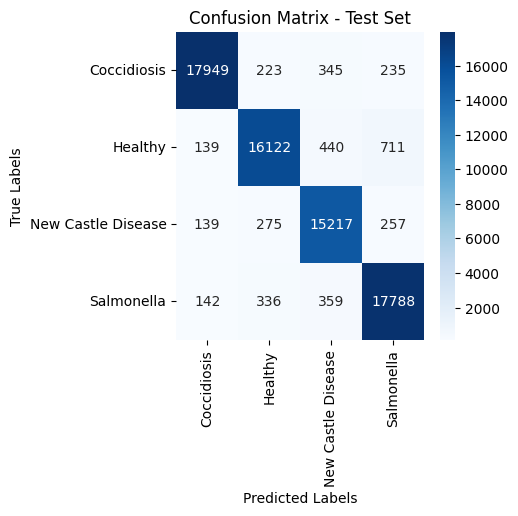

Confusion matrix saved as confusion_matrix.png


In [9]:
# Testing
model.eval()
class_labels = dataset.classes
correct_test = 0
total_test = 0
test_loss = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute and plot the confusion matrix for the final test set
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set")
plt.savefig("resnet18/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("Confusion matrix saved as confusion_matrix.png")

In [10]:
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                    precision    recall  f1-score   support

       Coccidiosis       0.98      0.96      0.97     18752
           Healthy       0.95      0.93      0.94     17412
New Castle Disease       0.93      0.96      0.94     15888
        Salmonella       0.94      0.96      0.95     18625

          accuracy                           0.95     70677
         macro avg       0.95      0.95      0.95     70677
      weighted avg       0.95      0.95      0.95     70677

